In [334]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras import optimizers
import scipy

import numpy as np
import time
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


def one_hot(y):
    oh = torch.zeros(y.shape[0],10) + 0.00000000000001
    for i in range(y.shape[0]):
        j = y[i].detach().numpy().astype('int16')
        oh[i,j] = 1.0
    return torch.tensor(oh, dtype=torch.float)

def cross_entropy(P,Q):
    H = - torch.sum(torch.matmul(P, torch.log(Q.transpose(1,0))))
    return(H)

In [350]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = torch.tensor(x_train, dtype=torch.float)

# y = one_hot(torch.tensor(y_train, dtype=torch.float)) # for MSEloss
y = torch.tensor(y_train,dtype=torch.long)          # for CrossEntropyLoss

x = x_train.view(-1,1,28,28)

In [355]:
"""
We first create and train a model that learns the features of numbers:
"""
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)
    
model = nn.Sequential(
    nn.Conv2d(1,32,5, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(32),
    nn.Conv2d(32,64,3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(64),
    Flatten(),
    nn.Linear(3136,10),
    nn.Softmax(dim=1)
)

print(model)

for i in model.parameters():
    i.requires_grad = True

optimizer = optim.Adam(model.parameters())
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
# criterion = cross_entropy

hist = []

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Flatten()
  (9): Linear(in_features=3136, out_features=10, bias=True)
  (10): Softmax()
)


Loss: 13.59
Loss: 13.16
Loss: 12.73
Loss: 12.30
Loss: 11.90
Loss: 11.50
Loss: 11.11
Loss: 10.73
Loss: 10.35
Loss: 9.98
Loss: 9.66
Loss: 9.32
Loss: 8.98
Loss: 8.65
Loss: 8.35
Loss: 8.04
Loss: 7.76
Loss: 7.47
Loss: 7.21
Loss: 6.94
Loss: 6.68
Loss: 6.42
Loss: 6.20
Loss: 5.97
Loss: 5.71
Loss: 5.50
Loss: 5.29
Loss: 5.07
Loss: 4.88
Loss: 4.69
Loss: 4.50
Loss: 4.33
Loss: 4.16
Loss: 3.99
Loss: 3.84
Loss: 3.65
Loss: 3.53
Loss: 3.39
Loss: 3.25
Loss: 3.11
Loss: 2.99
Loss: 2.89
Loss: 2.77
Loss: 2.65
Loss: 2.56
Loss: 2.48
Loss: 2.38
Loss: 2.29
Loss: 2.23
Loss: 2.16


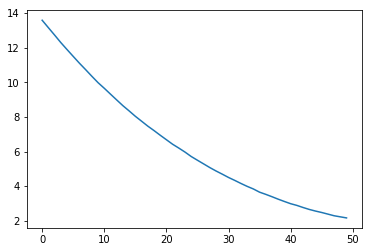

In [356]:
"""
We train the model for 20 epochs on batches of 1000 samples
"""

for i in range(50):
    samp = np.random.choice(60000, 1000).astype('int32').tolist()
    optimizer.zero_grad()

    predictions = model(x[samp,:,:,:])
#     targets = y[samp,:]   # for MSEloss
    targets = y[samp]    # otherwise

    loss = criterion(predictions, targets)
    
    # L1 and L2 regularization (Elastic Net) for the second conn2d layer ONLY:
    lmbda1, lmbda2 = 0.02, 0.02
    for p in model[4].parameters():
        loss += lmbda1 * torch.norm(p,1).sum()
        loss += lmbda2 * p.pow(2).sum()
        
    loss.backward()
    hist.append(loss)
    optimizer.step()
    print('Loss: {:.2f}'.format(loss.item()))

plt.plot(hist)

In [317]:
"""
Now we create an 'image' that we'll optimize though gradient descent. 
Hopefully, as we maximize the activation of one neuron (say, 0), we'll get the weights of the im that look
like zero.
"""
# im = Variable(torch.randn(1,1,28,28), requires_grad=True)
im = Variable(torch.zeros(1,1,28,28), requires_grad=True)

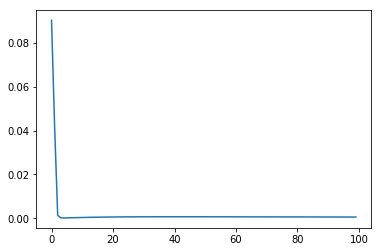

In [319]:
# we freeze all the paramters but the 'image' we'll do gradient descent on:
for i in model.parameters():
    i.requires_grad = False
    
optimizer = optim.Adam([im])
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
# criterion = cross_entropy
hist = []

for i in range(100):
    optimizer.zero_grad()

    predictions = model(im)
    targets = torch.tensor([1,0,0,0,0,0,0,0,0,0], dtype=torch.float).view(1,10)    # otherwise

    loss = criterion(predictions, targets)

    # L1 and L2 regularization (Elastic Net) for the IMAGE only (we leave the model paramters alone!):
    lmbda = 0.025
    loss += 0.0 * torch.norm(im,1).sum()
    loss += lmbda * torch.pow(im,2).sum()
    
    loss.backward()
    hist.append(loss)
    optimizer.step()
    
plt.plot(hist)

In [320]:
y[i]

tensor(1)

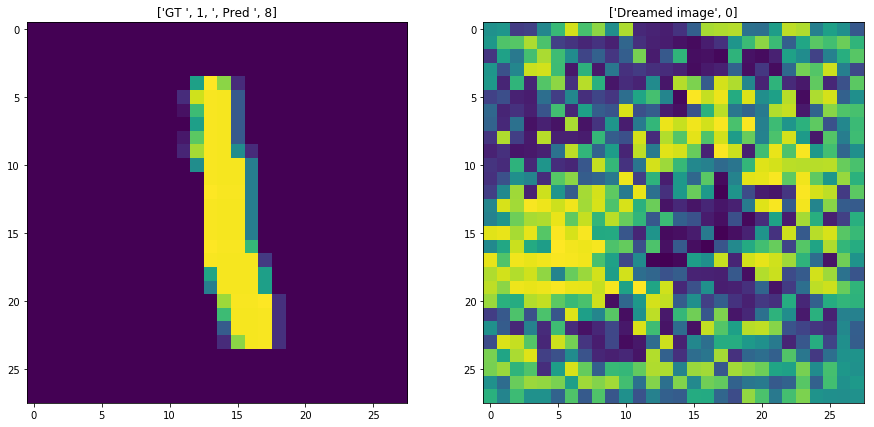

In [321]:
i = 6

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(x[i,:,:,:].reshape(28,28))
aa = plt.title(['GT ', y[i].item(), ', Pred ', torch.argmax(model(x[i,:,:,:].view(1,1,28,28))).item()])

plt.subplot(1,2,2)
plt.imshow(im.view(28,28).detach().numpy())
aa = plt.title(['Dreamed image', np.argmax(model(im).detach().numpy())])


In [307]:
model(im)

tensor([[0.0201, 0.8124, 0.0226, 0.0075, 0.0534, 0.0158, 0.0258, 0.0089, 0.0255,
         0.0082]], grad_fn=<SoftmaxBackward>)

In [374]:
Z = np.array(np.nonzero(y.detach().numpy()==0)).flatten().tolist()
Z_activations = model(x[Z,:,:,:]).detach().numpy()
for i in range(100):
    print(np.argmax(Z_activations[i,:]))

0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
6
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
2
0
0
0
0
0
0
0
0
0
0


In [375]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [376]:
data_dir = '/home/amplifier/home/NEW_DL/img/'

data_transforms = transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

train_dataset = torchvision.datasets.ImageFolder(
    root=data_dir,
    transform=data_transforms
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True
)

NameError: name 'transforms' is not defined

In [377]:
# you can get the data and labels WITH an ORDINAL NUMBER from generator using 'enumerate':
for batch_idx, (data, target) in enumerate(train_loader):
    inp = data
    t = target

NameError: name 'train_loader' is not defined

In [ ]:
# you can get the data and labels from generator like this:
for (data, target) in train_loader:
    print(target)

In [ ]:
print('Data shape: ', data.shape)
print('Targets: ', target)

In [ ]:
pred = vgg16(data.cuda())
dec = decode_predictions(pred.cpu().detach().numpy())

In [ ]:
plt.figure(figsize = (15,5))
for i in range(pred.shape[0]):
    plt.subplot(2,4,i+1)
    plt.imshow(data.detach().numpy()[i,:,:,:].transpose(1,2,0))
    plt.title(dec[i][0][1])
    plt.xticks([])
    plt.yticks([])

In [ ]:
"""
Now we create an 'image' that we'll optimize though gradient descent. 
Hopefully, as we maximize the activation of one neuron (say, 0), we'll get the weights of the im that look
like zero.
"""
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# im = Variable(torch.randn(1,3,224,224), requires_grad=True)

# transfer the image tensor and the model itself to CUDA:
im = Variable(torch.zeros(1,3,224,224), requires_grad=True).cuda()
vgg16.cuda()
print('The input tensor is now on:', im.device)
hist = []

In [ ]:
# we freeze all the paramters but the 'image' we'll do gradient descent on:
for i in vgg16.parameters():
    i.requires_grad = False
    
optimizer = optim.Adam([im])
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()


targets = torch.zeros(1,1000, dtype=torch.float)    # otherwise
targets[0,11] = 1.0

# targets = torch.tensor(6, dtype=torch.long).view(-1,1)

for i in range(100):
    optimizer.zero_grad()

    predictions = vgg16(im)

    loss = criterion(predictions, targets)

    # L1 and L2 regularization (Elastic Net) for the IMAGE only (we leave the model paramters alone!):
    lmbda = 0
    loss += 0.01 * torch.norm(im,1).sum()
    loss += 0.01 * torch.pow(im,2).sum()
    
    loss.backward()
    hist.append(loss)
    optimizer.step()
    
plt.plot(hist)

In [ ]:
dec = decode_predictions(targets.cpu().detach().numpy())
xx = im.cpu().detach().numpy()[0,1,:,:]
yy = vgg16(im).cpu().detach().numpy().flatten()
plt.imshow(xx)
plt.title([dec[0][0][1], np.argmax(yy)])
plt.colorbar()

In [ ]:
pred = vgg16(im).cpu().detach().numpy().flatten()

In [ ]:
print(np.argmax(pred), np.max(pred))

In [ ]:
xx = im.cpu().detach().numpy()[0,:,:,:].transpose(1,2,0)
scaled = (xx + 1)*1/2.
plt.imshow(scaled)

In [ ]:
print(list(vgg16.children())[1])
classifier = list(vgg16.children())[1]
clas_layers = list(classifier.children())
clas_layers.extend(nn.Softmax(dim=1))
clas_layers